# 3. Simulations and Visualization 

Simulatng models after the construction of the model can be very simple; from the simulation, various methods to visualize said simulations can help determine exactly the changes in flux and matter within the system based on the perturbations one gives within the systems. More on this will be discussed throughout this notebook. 

To start off, we use a Simulation object and this requires MassModel which is usually defined at the start of each simulation along with the other criteria's for building the model. Optimization of the model is inherent balanced throught the simulations unless otherwise specified; we will cover the basics of setting up simulations and work on optimizations later on in the workbook. 

In [1]:
from mass import Simulation

In [2]:
from mass import MassModel, MassMetabolite, MassReaction, plot_simulation, plot_phase_portrait

Some useful packages to help visualize simulations can be loaded at this time, 

In [3]:
import pandas as pd
import numpy as np 
import scipy as sym
import matplotlib.pyplot as plt

## 3.1 Simulate Models

For the sake of convinience, we will utilize our Complex Model which was used in the Building Models Example, 

<font color='red'>Zack will make the model a test model called "Small_Toy_Model" or similar</font>

$$\begin{equation} x_1 + x_2 \underset{v_{-1}}{\stackrel{v_1}{\rightleftharpoons}} x_3 \stackrel{v_2} \rightarrow x_4 \underset{v_{-3}}{\stackrel{v_3}{\rightleftharpoons}} x_5 \end{equation}$$ 

In [4]:
# Create MassModel
model = MassModel('Complex Model')
# Generate the MassMetabolites 
x1 = MassMetabolite("x1")
x2 = MassMetabolite("x2")
x3 = MassMetabolite("x3")
x4 = MassMetabolite("x4")
x5 = MassMetabolite("x5")
# Generate the MassReactions 
v1 = MassReaction("v1")
v2 = MassReaction("v2", reversible=False)
v3 = MassReaction("v3")
# Add metabolites to the reaction, add reaction to the model
v1.add_metabolites({x1: -1, x2: -1, x3: 1})
v2.add_metabolites({x3: -1, x4: 1})
v3.add_metabolites({x4: -1, x5: 1})
model.add_reactions([v1, v2, v3])
# Set parameters and initial conditions
v1.kf = 1
v1.Keq = 1
v2.kf = 1
v3.kf = 1
v3.Keq = 1
model.update_initial_conditions({x1: 1, x2: 1, x3: 0, x4: 0, x5:0 }, 
                                update_metabolites=True)

In [5]:
model

Name,Complex Model
Memory address,0x0122e04748
Stoichiometric Matrix,5x3
Matrix Rank,3
Matrix Type,"dense, float64"
Number of Metabolites,5
Number of Reactions,3
Number of Initial Conditions,5
Number of Forward Rate Constants,3
Number of Equilibrium Constants,3
Number of Irreversible Reactions,1


Let's simulate this model, 

<font color='red'>3.2.1 What is a Simulation object?
3.2.2 How does it work?</font>

### 3.1.1 Simulation Object

This process essentialy takes the model we created and simulates by integrating ODEs with our solver and given time points given a specific perturbation. Therefore, this would be the simulation object for masspy. Simulating the model once it is set up properly is very simple. Simulation object requires a MassModel initialization in order for the methods to be utilized. 

In [6]:
help(Simulation.simulate_model)

Help on function simulate_model in module mass.core.simulation:

simulate_model(self, model, time=None, perturbations=None, interpolate=True, verbose=True, return_obj=False, update_solutions=True, **options)
    Simulate a single MassModel and return the solution profiles.
    
    The "model" is simulated by integrating the ODEs using the solver
    set in self.solver to compute the solution at time points between the
    initial and final time points given in "time" while incorporating
    events specified in the "perturbations." See Simulation Module
    documentation for more information.
    
    Parameters
    ----------
    model: mass.MassModel or str
        The MassModel or the string identifier of the MassModel to
        simulate.
    time: tuple of floats
        A tuple containing the start and end time points of the simulation.
    perturbations: dict, optional
        A dict of events to incorporate into the simulation, where keys are
        the object and type of even

In [7]:
sim = Simulation(model)

### 3.1.2 Function of Simulation Objects

**Simulation.simulate_model** method integrates the ordinary differential equations within the system given that the time constraints are provided. The _output_ would be concentration and fluxes of the model system, 

*NOTE: We want to emphasize that this simulation is only valid for one model at any given time; simulation objects does not include multiple models*
<font color='red'>Emphasis its for one model only</font>

In [8]:
t0= 0 
tf= 1e6
conc_sol, flux_sol = sim.simulate_model(model, time=(t0,tf), verbose = True)

*NOTE*: There is a reason we set verbose as true when simulating models as there can be many times when the model has inconsistent data which corresponds to the simulations itself. If a model is unable to be simulated, there is a prompt as a response displaying a warning which will then pull up a QC/QA report which _highlights the inconsistencies, missing values, and any other issues_ to help assist and diagnose the problem within the model.

## 3.2 Inspection of Solutions

<font color='red'>3.2.1 What is a MassSolution object?
3.2.2 What can you do with it? (interpolate, putting a time point into the interpolate function, preview_time_profile, preview, .t, .tf, .t0)</font>

### 3.2.1 MassSolution Object

MassSolution object comprises all of the flux and concentration profiles which are created through the simulate model; specifically, a mass.Solution object with respect to the conc_sol contains the dictionary of concentration solutions given successful simulation. Similarily, flux_sol contains the flux solutions given a successful simulation utilizing mass.Solution. Thereby, MassSolution is a method for us to obtain concentrations and fluxes of the solutions (or both).

The default settings ensure that MassPy object Simulation uses scipy interpolating functions to construct corresponding flux and mass balances amongst the metabolites and the reactions given in order to derive concentrations and fluxes. **Simulation.simulate_model** returns two specified dictionary lists which are known as solution objects, 

The first Solution dictate MassMetabolite keys with their respective concentration solutions values,

In [9]:
conc_sol.solutions

{'x1': <scipy.interpolate.interpolate.interp1d at 0x122e75908>,
 'x2': <scipy.interpolate.interpolate.interp1d at 0x122e76458>,
 'x3': <scipy.interpolate.interpolate.interp1d at 0x122e766d8>,
 'x4': <scipy.interpolate.interpolate.interp1d at 0x122e76818>,
 'x5': <scipy.interpolate.interpolate.interp1d at 0x122e76958>}

Similarily, the second Solution distates the MassReaction keys with their respective flux solution values, 

In [10]:
flux_sol.solutions

{'v1': <scipy.interpolate.interpolate.interp1d at 0x122e757c8>,
 'v2': <scipy.interpolate.interpolate.interp1d at 0x122e749a8>,
 'v3': <scipy.interpolate.interpolate.interp1d at 0x122e74728>}

### 3.2.1 Query Time Response

<font color='red'>Better as subsection of 3.2</font>

Interpolating functions comprise of functions respective of time; evaluating the function and the corresponding system at a specific timepoint can be accomplished through, 

In [11]:
time_points= 100
for metabolite, interpolating_function in conc_sol.items():
    print ("%s: %s" % (metabolite, interpolating_function(time_points)))
for reaction, interpolating_function in flux_sol.items():
    print ("%s: %s" % (reaction, interpolating_function(time_points)))
print()

x1: 0.02029941848338077
x2: 0.02029941848338077
x3: 0.00020813483186141662
x4: 0.48979879049147956
x5: 0.489693656193278
v1: 0.00020393155888925594
v2: 0.00020813483186141662
v3: 0.0001051342982015467



Instead of just values for one point, we can get points for multiple points of time

In [12]:
time_points= [0.001, 0.01, 0.1, 1, 10, 100, 1000];
for metabolite, interpolating_function in conc_sol.items():
    print ("%s: %s" % (metabolite, interpolating_function(time_points)))
for reaction, interpolating_function in flux_sol.items():
    print ("%s: %s" % (reaction, interpolating_function(time_points)))
print()

x1: [0.9990015  0.99014803 0.9132163  0.61047647 0.18422871 0.02029942
 0.00200763]
x2: [0.9990015  0.99014803 0.9132163  0.61047647 0.18422871 0.02029942
 0.00200763]
x3: [9.98003274e-04 9.80263113e-03 8.23893397e-02 2.11206344e-01
 1.85878805e-02 2.08134832e-04 2.01731092e-06]
x4: [4.98980085e-07 4.91773075e-05 4.25052336e-03 1.32388620e-01
 4.03704479e-01 4.89798790e-01 4.98995682e-01]
x5: [2.01410074e-10 1.63864187e-07 1.43832631e-04 4.59285663e-02
 3.93478935e-01 4.89693656e-01 4.98994672e-01]
v1: [9.97005989e-01 9.70590486e-01 7.51574653e-01 1.61475168e-01
 1.53523352e-02 2.03931559e-04 2.01326042e-06]
v2: [9.98003274e-04 9.80263113e-03 8.23893397e-02 2.11206344e-01
 1.85878805e-02 2.08134832e-04 2.01731092e-06]
v3: [4.98778675e-07 4.90134433e-05 4.10669073e-03 8.64600535e-02
 1.02255445e-02 1.05134298e-04 1.00966927e-06]



Concentrations at these specific time stamps can be presented much more cleanly in a panda frame: 

In [13]:
data = [interpolating_function(time_points) for interpolating_function in conc_sol.values()]
index_col = [metabolite for metabolite in conc_sol.keys()]
pd.DataFrame(data, index=index_col, columns=time_points)

,0.001,0.01,0.1,1.0,10.0,100.0,1000.0
x1,9.990015e-01,9.901480e-01,0.913216,0.610476,0.184229,0.020299,0.002008
x2,9.990015e-01,9.901480e-01,0.913216,0.610476,0.184229,0.020299,0.002008
x3,9.980033e-04,9.802631e-03,0.082389,0.211206,0.018588,0.000208,0.000002
x4,4.989801e-07,4.917731e-05,0.004251,0.132389,0.403704,0.489799,0.498996
x5,2.014101e-10,1.638642e-07,0.000144,0.045929,0.393479,0.489694,0.498995


The same goes for reactions:

In [14]:
data = [interpolating_function(time_points) for interpolating_function in flux_sol.values()]
index_col = [reaction for reaction in flux_sol.keys()]
pd.DataFrame(data, index=index_col, columns=time_points)

,0.001,0.01,0.1,1.0,10.0,100.0,1000.0
v1,9.970060e-01,0.970590,0.751575,0.161475,0.015352,0.000204,0.000002
v2,9.980033e-04,0.009803,0.082389,0.211206,0.018588,0.000208,0.000002
v3,4.987787e-07,0.000049,0.004107,0.086460,0.010226,0.000105,0.000001


### 3.2.2 Filtering Specific Species & Fluxes

Concentration and flux solutions are specialized dictionaries within MassPy and function similar to any other dictionary. Capturing solutions for concentrations or fluxes using MassMetabolite and MassReaction identifiers as keys works the same as any other dictionary:

In [15]:
print(x1.id, conc_sol[x1.id])

x1 <scipy.interpolate.interpolate.interp1d object at 0x122e75908>


To iterate through multiple reactions, one can: 

In [16]:
for flux in [v1,v2]: 
    print(flux.id, flux_sol[flux.id])

v1 <scipy.interpolate.interpolate.interp1d object at 0x122e757c8>
v2 <scipy.interpolate.interpolate.interp1d object at 0x122e749a8>


### 3.2.3 Switching between numerical arrays and interpolating functions

If we want to work with original time plots instead of with ODE's to determine the corresponding solutions used by the ODE solver, we can do so by accessing the original time point values within the Solution Object and using these to interpolate the functions, 

In [17]:
time_points = conc_sol.t
#Function gets slice of all 1st 50 points
print(conc_sol["x1"](time_points[:50]))

[1.         0.999999   0.999998   0.99935003 0.99870332 0.99805786
 0.99436381 0.99137664 0.98841645 0.98548294 0.98257577 0.97683921
 0.97120433 0.9656687  0.96023001 0.95488598 0.93553741 0.91739526
 0.90035959 0.88434016 0.86925533 0.85503108 0.83374205 0.81426783
 0.7963935  0.77993319 0.76472564 0.75063056 0.73752555 0.72203462
 0.70779676 0.69464813 0.68244936 0.6710816  0.66044319 0.65044695
 0.63896779 0.62822378 0.61811734 0.6085667  0.59950321 0.59086897
 0.5799286  0.56957066 0.55971765 0.5503068  0.54128695 0.53261617
 0.52221091 0.51224292]


To convert an entire Solution object from interpolating functions to numerical assays or vice versa, we use the Solutions.interpolate setter method:

In [18]:
conc_sol.interpolate = False
conc_sol.solutions["x1"][:50]

array([1.        , 0.999999  , 0.999998  , 0.99935003, 0.99870332,
       0.99805786, 0.99436381, 0.99137664, 0.98841645, 0.98548294,
       0.98257577, 0.97683921, 0.97120433, 0.9656687 , 0.96023001,
       0.95488598, 0.93553741, 0.91739526, 0.90035959, 0.88434016,
       0.86925533, 0.85503108, 0.83374205, 0.81426783, 0.7963935 ,
       0.77993319, 0.76472564, 0.75063056, 0.73752555, 0.72203462,
       0.70779676, 0.69464813, 0.68244936, 0.6710816 , 0.66044319,
       0.65044695, 0.63896779, 0.62822378, 0.61811734, 0.6085667 ,
       0.59950321, 0.59086897, 0.5799286 , 0.56957066, 0.55971765,
       0.5503068 , 0.54128695, 0.53261617, 0.52221091, 0.51224292])

In [19]:
conc_sol.interpolate = True
conc_sol.solutions

{'x1': <scipy.interpolate.interpolate.interp1d at 0x122e7bae8>,
 'x2': <scipy.interpolate.interpolate.interp1d at 0x122e7b638>,
 'x3': <scipy.interpolate.interpolate.interp1d at 0x122e7b098>,
 'x4': <scipy.interpolate.interpolate.interp1d at 0x122e7b4a8>,
 'x5': <scipy.interpolate.interpolate.interp1d at 0x122e79f48>}

In [20]:
help(sym.interpolate)

Help on package scipy.interpolate in scipy:

NAME
    scipy.interpolate

DESCRIPTION
    Interpolation (:mod:`scipy.interpolate`)
    
    .. currentmodule:: scipy.interpolate
    
    Sub-package for objects used in interpolation.
    
    As listed below, this sub-package contains spline functions and classes,
    one-dimensional and multi-dimensional (univariate and multivariate)
    interpolation classes, Lagrange and Taylor polynomial interpolators, and
    wrappers for `FITPACK <http://www.netlib.org/dierckx/>`__
    and DFITPACK functions.
    
    Univariate interpolation
    
    .. autosummary::
       :toctree: generated/
    
       interp1d
       BarycentricInterpolator
       KroghInterpolator
       PchipInterpolator
       barycentric_interpolate
       krogh_interpolate
       pchip_interpolate
       Akima1DInterpolator
       CubicSpline
       PPoly
       BPoly
    
    
    Multivariate interpolation
    
    Unstructured data:
    
    .. autosummary::
       :t

Essentially, scipy interpolate functions help find the curve between two points in order to prdict values between two points; therefore, from concentration and flux solutions, scipy.interpolate uses mathematical methods to initialize values and distinguish a curve from just the reactions, metabolites and initial conditions we provided. 

Furthermore, array switching is particularily useful as we can bulk up the numerical values and create a list of the values which can be further analyzed through other methods and compared to our plot simulations in python

##### Something here detailing what we are trying to accomplish with the differentiation of the interpolating methods and why setting arrays is useful... 
<font color='blue'>Done</font>


## 3.3 Graphic Visualization of Models

<font color='red'>3.3 Visualization</font>

Visualization of the solutions can be easily completed through MassPy after simulation of the model;

In [21]:
import matplotlib.pyplot as plt
from mass.core.visualization import (plot_phase_portrait, plot_simulation, plot_tiled_phase_portrait, get_defaults,
                                   set_defaults, make_display_data)

The matplotlib pthon package was imported above but it was done again here just to clarigy the package corresponds to the visualization; the documentation for visualiation class can be viewed to determine more details for plotting kwargs.

### 3.3.1 Drawing Time Courses

Plotting dynamic simulations can be very simple with the __visualization.plot_simulations__ command,

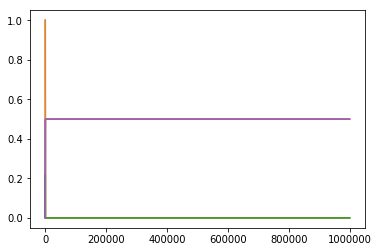

In [22]:
plot_simulation(conc_sol);

It is very apparent that this graph is useless in terms of determining the dynamic interactions between the metabolites within the reaction system. Furthermore, the time scale is much larger than what we can visualize and extract information from. To rectify this issue, we use __plot_function__ kwarg to change the scale such that we keep the y-axis as a linear scale and interpret the x axis through a lograthmic scale, 

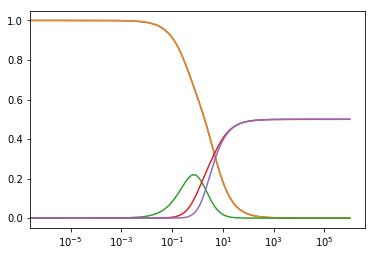

In [23]:
plot_simulation(conc_sol, plot_function = "semilogx")

Espiecially useful is the observable argument which specifies the particular solutions you want to view in your concentration profiles while filtering out other solutions. If we want to plot just x4 and x5 since they are so close, we can do,

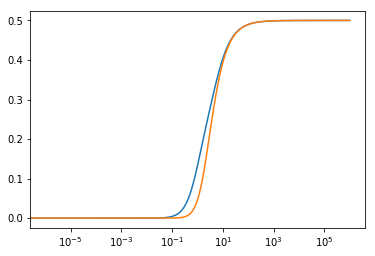

In [24]:
plot_simulation(conc_sol, observable=["x4", "x5"], plot_function = 'semilogx')

Furthermore, to analyze with more accurate information, it is necessary to add a title, axes labels and legends to the plot. Currently, the current default arguments can be viewed through __visualizations.get_defaults__ function and the syntax for each kwarg can be viwed through the __help__ function for *visualization.set_defaults*. View the previous notebooks to see a full detailed model on inspection of models. In order to do this, we can type: 

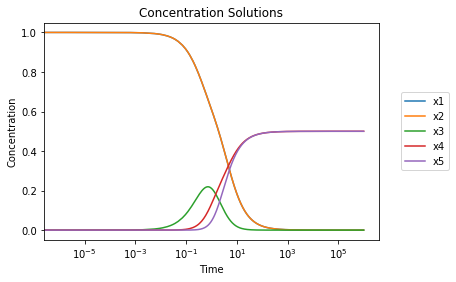

In [25]:
plot_simulation(conc_sol, legend = "right outside", plot_function="semilogx", xlabel = "Time", ylabel="Concentration",
               title = ("Concentration Solutions", {"size": "large"}))

### 3.3.2  Phase Portraits

Another way to display visualization of solutions is to plot one dynamic response of a metabolite against another metabolite; this can be acieved through the *visualization.plot_phase_portrait* method:

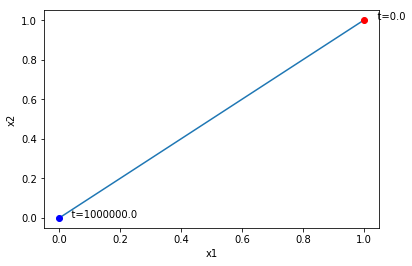

In [26]:
plot_phase_portrait(conc_sol, x="x1", y="x2", xlabel="x1", ylabel="x2")

*Note*: __time_poi__ can be used to highlight points of interest you want your specific plot to contain; this can be done in a number of ways, most commonly by either providing iterable time points as "points of interest" or using a dictionary with keys as the time points and values correspoinding to a specific color. In the following example, colors are used to discern each point so we can remove annotations for each point,

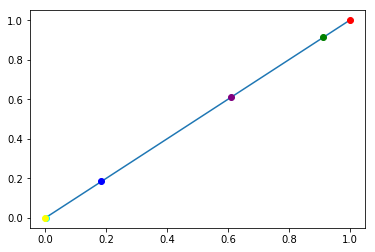

In [27]:
poi_dict = dict(zip([t0, 1e-1 , 1e0, 1e1, 1e3, tf], ["red", "green", "purple", "blue", "cyan", "yellow"]))
plot_phase_portrait(conc_sol, x="x1", y="x2", time_poi= poi_dict, poi_labels=False);

Multiple phase portraits can also be depicted with \\(x_1\\) simultaneously:  \\(x_1\\) vs \\(x_2\\), \\(x_1\\) vs \\(x_3\\), and \\(x_1\\) vs \\(x_4\\) can all be shown on the same phase portrait, 

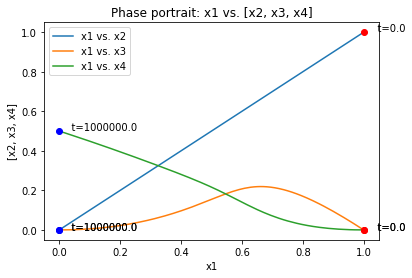

In [28]:
plot_phase_portrait(conc_sol, x=["x1"], y = ["x2", "x3", "x4"], legend ="best", xlabel = "x1", ylabel= "[x2, x3, x4]",
                    title = ("Phase portrait: x1 vs. [x2, x3, x4]", {"size":"large"}))

### 3.3.3 Tiled Phase Portraits

All pairwise phase portraits can be generated and viwed at once using the tiled phase portrait method: __visualization.plot_tiled_phase_portrait__

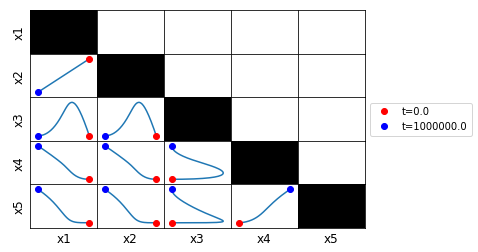

In [29]:
plot_tiled_phase_portrait(conc_sol)

This method is particularily useful for examining the dynamic behavior of metabolites for each pairwise metabolite concentrations over differing time scales in order to analyze their constraints and dependency for each of their respective fluxes. For example, from the overall behavior depicted above, using a fast timescale of (0,1), an intermediate scale from (3, 100) and a slow timescale of (300,1000) can be decomposed withinthe tiled phase portraits to analyze the solutions in depth, 

## 3.4 Post - Process Solutions

$$\begin{equation} x_1 + x_2 \underset{v_{-1}}{\stackrel{v_1}{\rightleftharpoons}} x_3 \stackrel{v_2} \rightarrow x_4 \underset{v_{-3}}{\stackrel{v_3}{\rightleftharpoons}} x_5 \end{equation}$$ 




__Assumptions:__ 

k1 >> k2 >> k3

Keq1 = Keq3 = 1

__Pools:__

p1 = x1 + x2 *(soft conservation)

p2 = x1 * x2 - x3/Keq *(standard disequilibrium)*

p3 = p1 - 2* x3 *(temporal disequilibrium)

p4 = x1 + x2 + x3 *(soft conservation)

p5 = x4 + x5 *(soft conservation)

p6 = x1 + x2 + x3 + x4 + x5 *(hard conservation)

Given that our reaction has so many dynamic behavior, there are more possibilities to pool the solution; however for our general case, we picked relevant ones which will help analyze solutions more succinctly.

#### 3.7.1 Analyzing Pool Behaviors

To analyze the behavior of pools, we can create __Simulation.make_pools__ methodology derived from strings in order to represent pool formulas. Different parameters can be incorporated to the pool formulation using dictionary input for __parameters__ argument. 

In [30]:
pools = ['x1 + x2','x1*x2 - x3', 'x1 + x2 - 2*x3', 'x1 + x2 + x3', 'x4 +x5', 'x1 +x2 +x3 +x4 +x5'] 
pool_sol = sim.make_pools(pools)
pool_sol.solutions

{'p1': <scipy.interpolate.interpolate.interp1d at 0x127aa3458>,
 'p2': <scipy.interpolate.interpolate.interp1d at 0x127b82a98>,
 'p3': <scipy.interpolate.interpolate.interp1d at 0x1272791d8>,
 'p4': <scipy.interpolate.interpolate.interp1d at 0x127b97278>,
 'p5': <scipy.interpolate.interpolate.interp1d at 0x127b97408>,
 'p6': <scipy.interpolate.interpolate.interp1d at 0x127b976d8>}

This tpye of function helps depict the entire solutions over different time ranges; *the interpolate function is not working for some reason; is this bc of the update?*

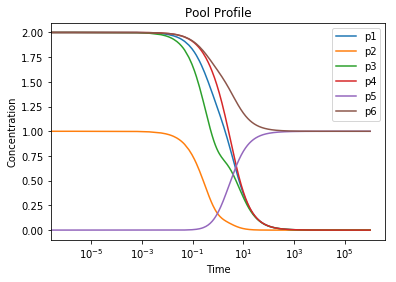

In [31]:
plot_simulation(pool_sol, plot_function= 'semilogx', xlabel='Time', ylabel='Concentration',
                title = ("Pool Profile",{"size":"large"}), legend = "best" )

#### 3.7.2 Computing Fluxes

Similar process can help derive behavior of the net flux through group of reactions utilizing __Simulation.make_net_fluxes__ method; both __Simulation.make_net_fluxes__ and __Simulation.make_pools__ rely on the __sympy.sympify__ function and can therefore use specific methodology within strings as well. Pull up sympy.sympify documentation through the help function for more help,

*Note:* Using dictionary inputs allows for pool and net flux IDs to be user-defined. 

In [32]:
net_fluxes = {"v_net_fluxes_1":'Abs(v1) + Abs(v2) + Abs(v3)'} #What is the different b/w apostrophe and quotes? 
net_flux_sol = sim.make_net_fluxes(net_fluxes)
net_flux_sol.solutions

{'v_net_fluxes_1': <scipy.interpolate.interpolate.interp1d at 0x1271922c8>}

As aforementioned, this function solutions for individual fluxes over a time range of specified input and creates new scipy interpolating functions representing behavior of various flux combinations.

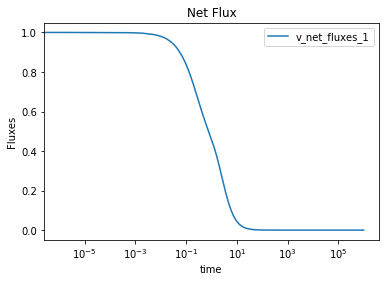

In [33]:
plot_simulation(net_flux_sol, legend="best", plot_function="semilogx", 
                xlabel="time", ylabel="Fluxes", 
                title=("Net Flux", {"size": "large"}));

#### 3.7.3 Plot Phase Portraits of Pools 

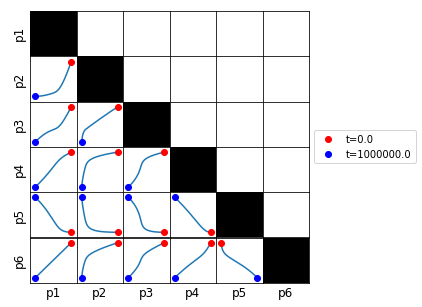

In [34]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
plot_tiled_phase_portrait(pool_sol, ax=ax)

From this depiction, we see how the metabolites are not dynamically independent of each other but are linearly dependent to some degree; more analysis of this can be visualized in other methods. 

## 3.5 Open Solution Simulations 

Let's now show how an entire model process should look like: starting from creating the model to plotting the simulations.

We can also simulate open models; for the sake of brevity, we are going to use a simpler function to detail how the open system simulation differs from the closed system,

Here we will simulate a very simple open solution, 

$$\begin{equation} \stackrel{b_1}{\rightarrow} x_1 \underset{v_{-1}}{\stackrel{v_1}{\rightleftharpoons}} x_2 \stackrel{b_2}{\rightarrow} \tag{6.1} \end{equation}$$

### 3.5.1 Simulate Open Solutions

__Creation of MassModel__

In [41]:
# Create MassModel
model = MassModel('Linear-Reversible-Open')

# Generate the MassMetabolites 
x1 = MassMetabolite("x1")
x2 = MassMetabolite("x2")

# Generate the MassReactions 
b1 = MassReaction("b1", reversible=False)
v1 = MassReaction("v1")
b2 = MassReaction("b2", reversible=False)

# Add metabolites to the reaction, add reaction to the model
b1.add_metabolites({x1: 1})
v1.add_metabolites({x1: -1, x2: 1})
b2.add_metabolites({x2: -1})
model.add_reactions([b1, v1, b2])

# Set parameters
b1.kf = 0.01
v1.kf, v1.kr = (1, 2)
b2.kf = 0.1

# Set initial conditions for model
x1.ic = 1
x2.ic = 0
model.set_initial_conditions()

# Set a custom rate for b1 to remove substrate concentration dependence
model.add_custom_rate(reaction=b1, custom_rate=b1.kf_str)

This type of formatting is what is expected when asked to create a simple model. Note the comments detailing the specific process that is being accomplished. Detailing your work and leaving comments is crucial in finding errors and having good documentation habits,

__Simulation__

In [46]:
t0 = 0
tf = 1e3

sim = Simulation(model)
conc_sol, flux_sol = sim.simulate_model(model, time=(t0, tf), interpolate=True, verbose=True)

__Visualization of Concentration and Flux Solutions__

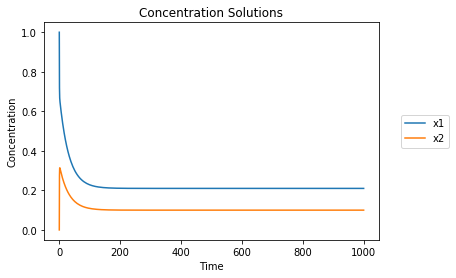

In [47]:
plot_simulation(conc_sol, legend = "right outside", xlabel = "Time", ylabel="Concentration",
               title = ("Concentration Solutions", {"size": "large"}))

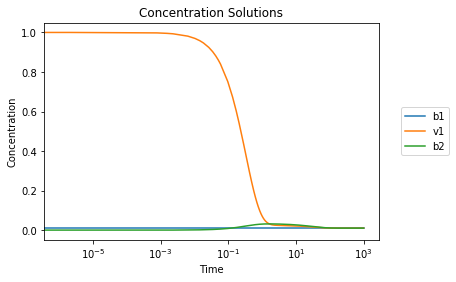

In [48]:
plot_simulation(flux_sol, plot_function= 'semilogx', legend = "right outside", xlabel = "Time", ylabel="Concentration",
               title = ("Concentration Solutions", {"size": "large"}))

For the sake of brevity, we will only display the concentration and flux solutions; however, for better data analysis, we might want to use other plots. What might those plots be? 

*(Hint: Consider the pools and discrepencies of one metabolite concentration/flux to the other)*

### 3.5.2 QC/QA Models 

QC/QA models help ensure that we have accurate models which depict our data correctly and precisely. QC/QA are usually conducted with two types of test: one is to check and make sure that the addition of influx and outflux of materials in an open system add up to one or by checking enzyme pools (covered at a later point in the chapter) at various time points; we will show both methods and how to distinguish whther the model is correct or not. Currently, we will only display the addition of influx and outflux method: 

#### Method: Addition of influx and outflux

This method relies on the fact that the system eventually reaches steady state. Once it does, we can evaluate the v1 and b2 to see if the rates are proportional to each other suggesting that the system is in equilibrium. 

In [49]:
time_points = [1e0, 1e1, 1e2, 1e3]
# Make a pandas DataFrame using a dictionary and generators
pd.DataFrame({rxn: [round(value, 3) for value in flux_func(time_points)]
              for rxn, flux_func in flux_sol.items()}, 
             index=["t=%i" % t for t in time_points])

,b1,v1,b2
t=1,0.01,0.070,0.031
t=10,0.01,0.021,0.026
t=100,0.01,0.011,0.011
t=1000,0.01,0.010,0.010


From noting the values above, we see that @ t=1000, v1 and b2 are the same values, indicating fluxes between the the reactions are the same meaning they are in equilibrium to each other, and thereby reached steady state efficiently. 

#### Method 2: Summation of Enzyme Pool *****

In [40]:
#We don't have enzyme reactions yet? 